In [14]:
import gensim
import gzip
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import pickle
import we

#Reproducibility
SEED = 42 #The answer to everything
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [15]:
!ls 

 Adversarial_Training.ipynb  'GANv4 - no random.ipynb'	  rGANv1.ipynb
 GANv1.5_neighbour.ipynb     'Modify vectors.ipynb'	  tests
 GANv1.ipynb		     'Ours + Adversarial.ipynb'   we.py
 GANv3_learnOpposite.ipynb    __pycache__


In [26]:
EMB = '../../../Research Work/Gender_Bias/embeddings/glove' 

In [27]:
E = we.WordEmbedding(EMB)

*** Reading data from ../../../Research Work/Gender_Bias/embeddings/glove
Loading numpy format
loading ...
(322636, 300)
322636 words of dimension 300 : the, of, and, in, ..., zuras, zuriel, zyuzin, <unk>
322636 words of dimension 300 : the, of, and, in, ..., zuras, zuriel, zyuzin, <unk>


In [31]:
# E.v('test')

# Helper functions

In [37]:
def normalize(v):
    return v / np.linalg.norm(v)

def get_max(E, g, words):
    df = pd.DataFrame(data={"word": list(words)})
    b = {}
    for word in tqdm(words):
        b[word] = get_gender_logit(word, E, g)
    df['gender_score'] = df.word.map(b) 
    df.sort_values(by='gender_score', inplace=True)
    return df

def gender_subspace(E):
        pairs = [
              ("woman", "man"),
              ("her", "his"),
              ("she", "he"),
              ("aunt", "uncle"),
              ("niece", "nephew"),
              ("daughters", "sons"),
              ("mother", "father"),
              ("daughter", "son"),
              ("granddaughter", "grandson"),
              ("girl", "boy"),
              ("stepdaughter", "stepson"),
              ("mom", "dad"), ]
        difs = []    
        for f, m in pairs:
            difs.append(E.v(f)- E.v(m))
        difs = np.array(difs)
        #PCA
        difs = np.cov(np.array(difs).T)
        evals, evecs = np.linalg.eig(difs)
        return normalize(np.real(evecs[:, np.argmax(evals)]))

def gender_subspace_simple(E):
    return normalize(E.v('she') - E.v('he'))    

# def load_words():
#     words = []
#     with open('w2v_gnews_small.vocab', 'r') as handle:
#         for line in handle.readlines():
#             words.append(line.strip())
#     return words       
# words = load_words()

file = "limited_vocab.hila"
with open(file, 'rb') as handle:
    words = pickle.load(handle)

def get_gender_logit(word, E, g):
    return E.v(word).dot(g) 

def get_gender(word, E, g):
    return 1 if E.v(word).dot(g) < 0 else 0 #1 is Male, 0 is female

def get_rgender(word, E, g):
    return 0 if E.v(word).dot(g) < 0 else 1 #reversed gender

def label_to_gender(label):
    return 'M' if label else 'F'

# g = gender_subspace(E)
g = gender_subspace_simple(E)

## Clean vocab

In [39]:
for w in words:
    if w not in E.words:
        words.remove(w)

# DataLoader

In [44]:
class gender_set(Dataset):
    def __init__(self, words, E, g, device):
        self.words = words
        self.embs = torch.Tensor([E.v(w) for w in words]).to(device)
        self.gender = torch.Tensor([get_gender(w, E, g) for w in words]).to(device)
        self.rgender = torch.Tensor([get_rgender(w, E, g) for w in words]).to(device)
        
    def __len__(self):
        return len(self.words)
    
    def __getitem__(self, idx):
        return self.words[idx], self.embs[idx], self.gender[idx], self.rgender[idx]

In [45]:
bs = 128 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = gender_set(words, E, g, device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [46]:
# test dataloader
for i, (word, emb, gender, rgender) in enumerate(train_loader):
    for w, gen in zip(word, gender):
        print(w, gen.data)
    break    

grammy tensor(0., device='cuda:0')
thinning tensor(0., device='cuda:0')
nfb tensor(0., device='cuda:0')
denials tensor(1., device='cuda:0')
frustration tensor(0., device='cuda:0')
schooner tensor(0., device='cuda:0')
subtraction tensor(0., device='cuda:0')
afield tensor(1., device='cuda:0')
foresters tensor(1., device='cuda:0')
symmetries tensor(0., device='cuda:0')
cinque tensor(0., device='cuda:0')
haye tensor(1., device='cuda:0')
hubs tensor(0., device='cuda:0')
created tensor(1., device='cuda:0')
fifths tensor(0., device='cuda:0')
biochemistry tensor(1., device='cuda:0')
huffington tensor(0., device='cuda:0')
monroe tensor(1., device='cuda:0')
succulent tensor(0., device='cuda:0')
stroke tensor(1., device='cuda:0')
organists tensor(1., device='cuda:0')
torbay tensor(0., device='cuda:0')
wildcat tensor(1., device='cuda:0')
forte tensor(0., device='cuda:0')
grandis tensor(0., device='cuda:0')
mocks tensor(0., device='cuda:0')
expenditures tensor(1., device='cuda:0')
pataki tensor(1.,

# GAN
### Generator

In [47]:
class Generator(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.fc1 = nn.Linear(nz, 300)
        self.act = nn.LeakyReLU()
        self.model = nn.Sequential(
            nn.Linear(600, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 300),
        )
    
    def forward(self, z, c):
        x = self.act(self.fc1(z))
        x = torch.cat([x, c], dim=1)
        x = self.model(x)
        return x / torch.norm(x) #return normalized embedding

# netG = Generator(z_dim)
# z = torch.randn((z_dim))
# netG(z, torch.Tensor(E['man']))

### Discriminator

In [48]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(300, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
        )
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.model(x)
        return self.sig(x).squeeze()

# d = Discriminator()
# d.forward(torch.Tensor(E['test']))    

### Hyperparameters

In [53]:
nz = 128
lrd = 1e-3
lrg = 1e-2
beta1 = 0.5
epochs = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = gender_set(words, E, g, device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lrd, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrg, betas=(beta1, 0.999))

z = torch.randn(bs, nz, device=device) #Fixed noise

def get_new_emb(word, netG):
    return netG(z[0].unsqueeze(dim=0), torch.Tensor(E.v(word)).unsqueeze(dim=0).to(device))

def test_generator(netG, g, device):
    with torch.no_grad():
        word_list = "nanny engineer warrior boss midwife".split()
        for word in word_list:
            orig = torch.Tensor(E.v(word)).to(device)
            new = get_new_emb(word, netG).squeeze()
            similarity = new.dot(orig)
            bias_bef = orig.dot(torch.Tensor(g).to(device))
            bias_aft = new.dot(torch.Tensor(g).to(device))        
            print(f"Word: {word} Similarity: {similarity:.5f} | Bias: {bias_bef:.5f} / {bias_aft:.5f}")

### Train

In [54]:
G_losses = []
G_Glosses = []
G_Mlosses = []
D_losses = []
D_Flosses = []
D_Rlosses = []

for epoch in tqdm(range(epochs)):
    for i, (word, emb, gender, rgender) in enumerate(train_loader):
        #######################
        # Update netD
        #######################
        netD.zero_grad()
        outputR = netD(emb)
        errD_real = criterion1(outputR, gender) #train discriminator to classify real data as Male or Female
        errD_real.backward()
        
#         noise = z[:emb.shape[0], :] #Fixed noise
        noise = torch.randn(emb.shape[0], nz, device=device) #Random noise
        
        fake = netG(noise, emb)
        outputF = netD(fake.detach()) #Detach, we don;t want D to change G's weights
        errD_fake = criterion1(outputF, gender) #train discriminator to classify generated data as Male or Female
        errD_fake.backward(retain_graph=True)
        errD = errD_real + errD_fake
        
        optimizerD.step()
        
        ########################
        # Update netG
        ########################
        netG.zero_grad()
#         errG_meaning = criterion2(fake, emb)
#         M = torch.abs(fake - emb).mean()
        M = torch.abs(torch.bmm(fake.unsqueeze(1), emb.unsqueeze(2))).mean()    
        G = torch.abs(torch.matmul(fake, torch.Tensor(g).to(device))).mean()
        errG_meaning = 15*G - 5*M #We want to maximize M and minimize G
        errG_meaning.backward(retain_graph=True)
        
        errG_gender = criterion1(outputF, rgender) #fooling discriminator = how well has it predicted the opposite label (rgender) = how bad has it predicted 
        errG_gender.backward()
        errG = errG_gender + errG_meaning
        
        optimizerG.step()
        
    if (epoch+1) % 10 == 0:
        print(f"Epoch: [{epoch+1} / {epochs}]")
        print(f"errD_real: {errD_real:.3f} | errD_fake: {errD_fake:.3f} | errG_gender: {errG_gender:.3f} | errG_meaning: {errG_meaning:.5f}")    
        test_generator(netG, g, device)
        
    D_losses.append(errD.item())    
    D_Flosses.append(errD_fake.item())    
    D_Rlosses.append(errD_real.item())    

    G_losses.append(errG.item())
    G_Glosses.append(errG_gender.item())
    G_Mlosses.append(errG_meaning.item())        

Epoch: [10 / 1000]
errD_real: 0.000 | errD_fake: 0.477 | errG_gender: 1.681 | errG_meaning: -0.39314
Word: nanny Similarity: -0.80370 | Bias: 0.17054 / 0.05542
Word: engineer Similarity: -0.90484 | Bias: -0.16721 / 0.04978
Word: warrior Similarity: -0.87669 | Bias: 0.05222 / 0.04493
Word: boss Similarity: -0.87149 | Bias: -0.04070 / 0.04463
Word: midwife Similarity: -0.82738 | Bias: 0.22603 / 0.04563
Epoch: [20 / 1000]
errD_real: 0.020 | errD_fake: 0.359 | errG_gender: 2.781 | errG_meaning: -0.46177
Word: nanny Similarity: -0.91903 | Bias: 0.17054 / 0.04824
Word: engineer Similarity: -0.95964 | Bias: -0.16721 / 0.02759
Word: warrior Similarity: -0.95735 | Bias: 0.05222 / 0.03855
Word: boss Similarity: -0.95839 | Bias: -0.04070 / 0.03610
Word: midwife Similarity: -0.90989 | Bias: 0.22603 / 0.04021
Epoch: [30 / 1000]
errD_real: 0.016 | errD_fake: 0.179 | errG_gender: 5.889 | errG_meaning: -0.47133
Word: nanny Similarity: -0.93658 | Bias: 0.17054 / 0.04347
Word: engineer Similarity: -0.96

Epoch: [220 / 1000]
errD_real: 0.000 | errD_fake: 0.102 | errG_gender: 16.276 | errG_meaning: -0.50822
Word: nanny Similarity: -0.97229 | Bias: 0.17054 / 0.01148
Word: engineer Similarity: -0.98055 | Bias: -0.16721 / 0.01693
Word: warrior Similarity: -0.99134 | Bias: 0.05222 / 0.01723
Word: boss Similarity: -0.99220 | Bias: -0.04070 / 0.01830
Word: midwife Similarity: -0.96008 | Bias: 0.22603 / 0.01514
Epoch: [230 / 1000]
errD_real: 0.000 | errD_fake: 0.008 | errG_gender: 15.157 | errG_meaning: -0.49117
Word: nanny Similarity: -0.97124 | Bias: 0.17054 / -0.00814
Word: engineer Similarity: -0.97269 | Bias: -0.16721 / -0.00358
Word: warrior Similarity: -0.98983 | Bias: 0.05222 / -0.00331
Word: boss Similarity: -0.98815 | Bias: -0.04070 / -0.00476
Word: midwife Similarity: -0.95918 | Bias: 0.22603 / -0.00588
Epoch: [240 / 1000]
errD_real: 0.000 | errD_fake: 0.102 | errG_gender: 14.341 | errG_meaning: -0.50824
Word: nanny Similarity: -0.97272 | Bias: 0.17054 / 0.01607
Word: engineer Simila

Epoch: [430 / 1000]
errD_real: 0.000 | errD_fake: 0.109 | errG_gender: 21.304 | errG_meaning: -0.51446
Word: nanny Similarity: -0.98050 | Bias: 0.17054 / -0.01588
Word: engineer Similarity: -0.97941 | Bias: -0.16721 / -0.01162
Word: warrior Similarity: -0.99512 | Bias: 0.05222 / -0.00445
Word: boss Similarity: -0.99266 | Bias: -0.04070 / -0.00786
Word: midwife Similarity: -0.97029 | Bias: 0.22603 / -0.01369
Epoch: [440 / 1000]
errD_real: 0.000 | errD_fake: 0.083 | errG_gender: 18.139 | errG_meaning: -0.51560
Word: nanny Similarity: -0.98067 | Bias: 0.17054 / -0.01079
Word: engineer Similarity: -0.98083 | Bias: -0.16721 / -0.00433
Word: warrior Similarity: -0.99522 | Bias: 0.05222 / -0.00317
Word: boss Similarity: -0.99450 | Bias: -0.04070 / -0.00564
Word: midwife Similarity: -0.97035 | Bias: 0.22603 / -0.01029
Epoch: [450 / 1000]
errD_real: 0.000 | errD_fake: 0.008 | errG_gender: 17.905 | errG_meaning: -0.51695
Word: nanny Similarity: -0.98067 | Bias: 0.17054 / -0.01180
Word: engineer 

Epoch: [640 / 1000]
errD_real: 0.000 | errD_fake: 0.008 | errG_gender: 19.687 | errG_meaning: -0.52007
Word: nanny Similarity: -0.98011 | Bias: 0.17054 / 0.00216
Word: engineer Similarity: -0.98374 | Bias: -0.16721 / 0.00382
Word: warrior Similarity: -0.99614 | Bias: 0.05222 / 0.00122
Word: boss Similarity: -0.99649 | Bias: -0.04070 / 0.00479
Word: midwife Similarity: -0.97026 | Bias: 0.22603 / 0.00083
Epoch: [650 / 1000]
errD_real: 0.000 | errD_fake: 0.018 | errG_gender: 20.233 | errG_meaning: -0.52091
Word: nanny Similarity: -0.97973 | Bias: 0.17054 / 0.00837
Word: engineer Similarity: -0.98426 | Bias: -0.16721 / 0.00523
Word: warrior Similarity: -0.99580 | Bias: 0.05222 / 0.00533
Word: boss Similarity: -0.99531 | Bias: -0.04070 / 0.00399
Word: midwife Similarity: -0.96795 | Bias: 0.22603 / 0.00692
Epoch: [660 / 1000]
errD_real: 0.000 | errD_fake: 0.000 | errG_gender: 21.255 | errG_meaning: -0.52039
Word: nanny Similarity: -0.98244 | Bias: 0.17054 / -0.00596
Word: engineer Similarity

Epoch: [850 / 1000]
errD_real: 0.000 | errD_fake: 0.000 | errG_gender: 22.644 | errG_meaning: -0.52288
Word: nanny Similarity: -0.98367 | Bias: 0.17054 / -0.00480
Word: engineer Similarity: -0.98303 | Bias: -0.16721 / -0.00573
Word: warrior Similarity: -0.99673 | Bias: 0.05222 / -0.00603
Word: boss Similarity: -0.99665 | Bias: -0.04070 / -0.00261
Word: midwife Similarity: -0.97262 | Bias: 0.22603 / -0.00574
Epoch: [860 / 1000]
errD_real: 0.000 | errD_fake: 0.004 | errG_gender: 22.743 | errG_meaning: -0.52215
Word: nanny Similarity: -0.98390 | Bias: 0.17054 / -0.00628
Word: engineer Similarity: -0.98329 | Bias: -0.16721 / -0.00301
Word: warrior Similarity: -0.99672 | Bias: 0.05222 / -0.00227
Word: boss Similarity: -0.99606 | Bias: -0.04070 / -0.00496
Word: midwife Similarity: -0.97290 | Bias: 0.22603 / -0.00671
Epoch: [870 / 1000]
errD_real: 0.000 | errD_fake: 0.000 | errG_gender: 20.119 | errG_meaning: -0.52320
Word: nanny Similarity: -0.98270 | Bias: 0.17054 / 0.00165
Word: engineer S

In [86]:
PATH_D = "models/D.pth"
PATH_G = "models/G.pth"
torch.save(netG.state_dict(), PATH_G)
torch.save(netD.state_dict(), PATH_D)
print("Models saved")

Models saved


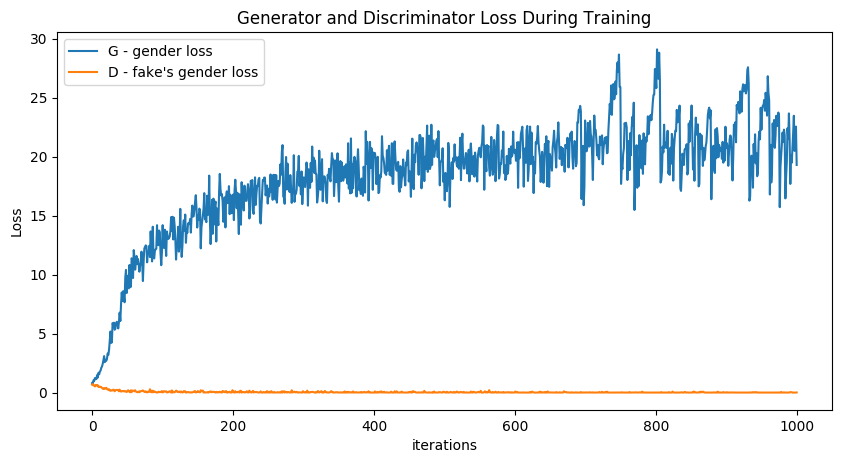

In [56]:
plt.figure(figsize=(10,5), dpi=100)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_Glosses, label="G - gender loss")
plt.plot(D_Flosses, label="D - fake's gender loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Both are different losses, better plot seperately

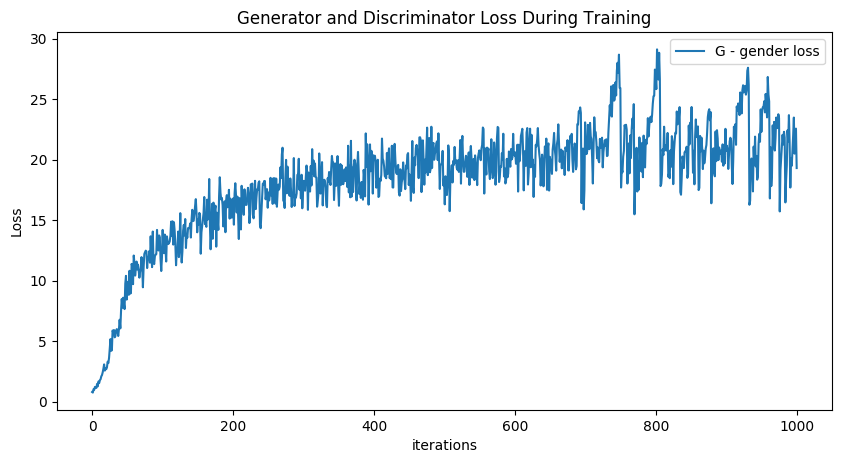

In [57]:
plt.figure(figsize=(10,5), dpi=100)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_Glosses, label="G - gender loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

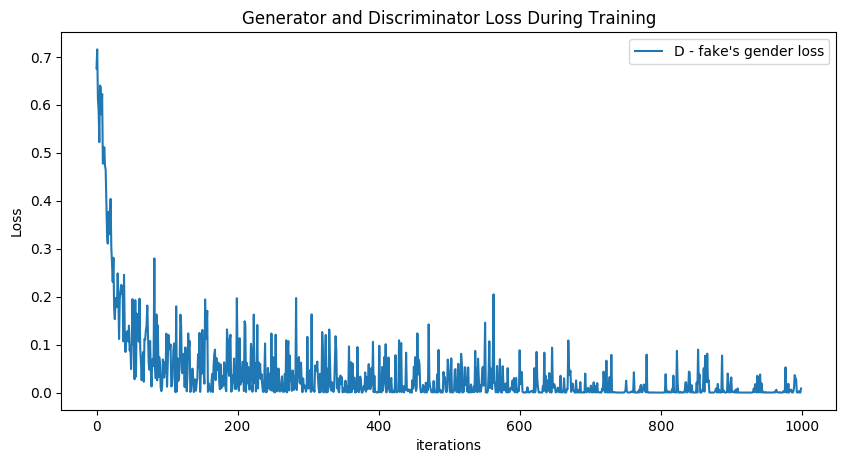

In [58]:
plt.figure(figsize=(10,5), dpi=100)
plt.title("Discriminator Loss During Training")
plt.plot(D_Flosses, label="D - fake's gender loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [59]:
wds = "any word can go here it will have similar meaning okay anything at all".split()
for w in wds:
    orig = torch.Tensor(E.v(w)).to(device)
    new = get_new_emb(w, netG).squeeze()
    sim = new.dot(orig)
    print(f"{w}: {sim}")

any: -0.9937635660171509
word: -0.9972375631332397
can: -0.9982516169548035
go: -0.9987564086914062
here: -0.9939884543418884
it: -0.9957798719406128
will: -0.9971675276756287
have: -0.996321439743042
similar: -0.9970186948776245
meaning: -0.9971277713775635
okay: -0.9871394634246826
anything: -0.9986513257026672
at: -0.9956119656562805
all: -0.9928355813026428


# Analogy tests

In [66]:
def find_closest(new, k=100, E=E):
    dots = new.dot(E.vecs.T)
    dd = dict(zip([abs(dot) for dot in dots], [i for i in range(len(dots))]))
    ns=[]
    thresh = 1.5
    for dot in sorted(dd, reverse=True):
        if True:
            ns.append(E.words[int(dd[dot])])
    return ns[:k]

In [62]:
def E_deb(word):
    return get_new_emb(word, netG).squeeze().detach().cpu().numpy()

In [64]:
before = 0
after = 0
for word in tqdm(words):
    before += np.abs(E.v(word).dot(g))
    after += np.abs(E_deb(word).dot(g))
print(before/len(words))    
print(after/len(words))    


0.05725555202486781
0.0045502590794699775


#### As seen above, the average direct bias has reduced significantly, this is a good thing
## Now, Some analogies to show gender bias

In [84]:
# Original embeddings
A = E.v("man")
B = E.v("woman")
C = E.v("programmer")

V = B + C - A

find_closest(V, 20)

['programmer',
 'programmers',
 'researcher',
 'designer',
 'educator',
 'computer',
 'freelance',
 'animator',
 'writer',
 'developer',
 'editor',
 'businesswoman',
 'compiler',
 'librarian',
 'interpreter',
 'translator',
 'blogger',
 'analyst',
 'organizer',
 'software']

In [82]:
# Out debiased embeddings
A = E_deb("man")
B = E_deb("woman")
C = E_deb("programmer")

V = B + C - A

find_closest(V, 20)

['programmer',
 'programmers',
 'researcher',
 'designer',
 'computer',
 'educator',
 'animator',
 'developer',
 'writer',
 'editor',
 'freelance',
 'compiler',
 'librarian',
 'interpreter',
 'organizer',
 'translator',
 'analyst',
 'software',
 'user',
 'author']

In [70]:
E_deb("programmer").dot(E.v("programmer"))

-0.9969274

In [72]:
E.v("programmer").dot(g)

-0.05422006

In [71]:
E_deb("programmer").dot(g)

0.003285324

### Some analogies to show meaning

In [76]:
# Original embeddings
A = E.v("usa")
B = E.v("pizza")
C = E.v("japan")

V = B + C - A

find_closest(V, 10)

['pizza',
 'japan',
 'sushi',
 'domino',
 'japanese',
 'pasta',
 'kfc',
 'sandwiches',
 'restaurant',
 'pizzas']

In [77]:
# Out debiased embeddings
A = E_deb("usa")
B = E_deb("pizza")
C = E_deb("japan")

V = B + C - A

find_closest(V, 10)

['pizza',
 'sushi',
 'japan',
 'pasta',
 'domino',
 'japanese',
 'sandwiches',
 'kfc',
 'restaurant',
 'hokkaido']

In [78]:
# Original embeddings
A = E.v("grass")
B = E.v("green")
C = E.v("sky")


V = B + C - A

find_closest(V, 10)

['sky',
 'green',
 'blue',
 'bright',
 'red',
 'dark',
 'star',
 'colour',
 'yellow',
 'light']

In [79]:
# Out debiased embeddings
A = E_deb("grass")
B = E_deb("green")
C = E_deb("sky")

V = B + C - A

find_closest(V, 10)

['sky',
 'green',
 'blue',
 'bright',
 'red',
 'dark',
 'star',
 'colour',
 'light',
 'yellow']

# Debias all words
:( Cuda memory error

In [37]:
# This gives a CUDA memory error, I need a better GPU :( :( :( :( :( :( :( :( 
# z = torch.randn(3000000, nz, device=device)
# netG(z, E.vectors)

# Save limited word embeddings

In [38]:
debs = {}
for word in tqdm(words):
    debs[word] = E_deb(word)

In [39]:
import pickle

with open("GloVe_dev.dict.pickle", 'wb') as handle:
    pickle.dump(debs, handle)